(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic

# Import package to save outputs
import BSON

# Import statistical functions
import Random
import StatsBase
import Distributions

# Import basic math
import LinearAlgebra

# Import ML libraries
import Flux
import NNlib
import SimpleChains
import Zygote

# Import library to perform Einstein summation
import Einsum

# Import differential equations solver
import DifferentialEquations as DiffEq

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Differential geometry of latent space

`[explanation here]`

## Simple 3D example

To begin our exploration of the differential geometry ideas, let's work with a
simple example. Let us define a function of the form
$$
\underline{f}(x_1, x_2) =
\begin{bmatrix}
    x_{1}\\
    x_{2}\\
    \exp(- (x_{1}^2 + x_{2}^2))\\
\end{bmatrix}.
$$
This function will serve as our playground to have visual intuition about the
resulting latent space geometry.

In [2]:
# Define function
f(x₁, x₂) = exp(-(x₁^2 + x₂^2))

# Define complete vector function
f̲(x) = [x[1], x[2], f(x[1], x[2])]

f̲ (generic function with 1 method)

Let's generate a random set of numbers sampling points on the $x_1-x_2$ plane
that lie inside a circle of radius $r$. Furthermore, we will map these points to
3D space using our function $\underline{f}$.

In [3]:
Random.seed!(42)

# Define number of points to sample
n_sample = 1_000

# Defien radius
radius = 3

# Sample random radius
r_rand = radius .* sqrt.(Random.rand(n_sample))

# Sample random angles
θ_rand = 2π .* Random.rand(n_sample) 

# Convert form polar to cartesian coordinates
x_rand = Float32.(r_rand .* cos.(θ_rand))
y_rand = Float32.(r_rand .* sin.(θ_rand))
# Feed numbers to function
z_rand = f.(x_rand, y_rand)

# Compile data into matrix
data = Matrix(hcat(x_rand, y_rand, z_rand)')

3×1000 Matrix{Float32}:
 -1.1037    -0.130005   1.22947    …  -1.85835      2.19925      0.88909
  0.586526  -1.69648    0.903149      -1.71827     -1.69536      0.856582
  0.20968    0.0553015  0.0975618      0.00165177   0.000447911  0.217792

Now, let's take a look at both the input and output space for our function. We
will color the points by the $z$-value given by our function $\underline{f}$.

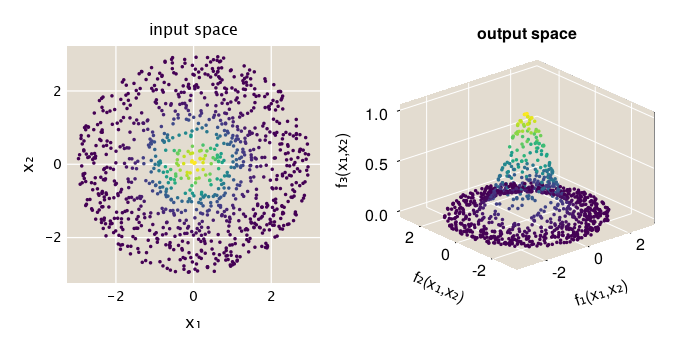

In [4]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for input space
ax_input = Axis(
    gl[1, 1],
    xlabel="x₁",
    ylabel="x₂",
    title="input space"
)

# Plot input space
scatter!(
    ax_input,
    x_rand,
    y_rand,
    markersize=5,
    color=z_rand,
    colormpa=:viridis
)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(x₁,x₂)",
    ylabel="f₂(x₁,x₂)",
    zlabel="f₃(x₁,x₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Plot output space
scatter!(
    ax_output,
    data[1, :],
    data[2, :],
    data[3, :],
    markersize=5,
    color=data[3, :],
    colormap=:viridis,
)

# Separate axis
colgap!(gl, 50)

fig

This looks like a very useful function on which to test the
differential-geometry ideas and gain visual intuition.

### Computing the Riemmanian metric

`[explanation here]`

In [9]:
# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-radius * 1.1, radius * 1.1, n_range)

# Initialize matrix to save metric
manifold_metric = Matrix{Float32}(undef, n_range, n_range)

# Loop through first latent variable
for (i, x) in enumerate(z1)
    # Loop through second latent variable
    for (j, y) in enumerate(z2)
        # Compute Jacobian
        jac = first(Zygote.jacobian(f̲, [x, y]))
        # Compute and save metric
        manifold_metric[i, j] = sqrt(LinearAlgebra.det(jac' * jac))
    end # for
end # for

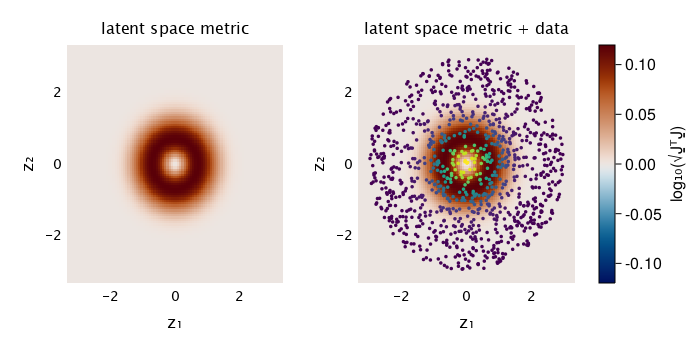

In [10]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add axis for latent space
ax1 = Axis(
    fig[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Define range of values
colorrange = (
    - maximum(
        abs.(
            [minimum(log10.(manifold_metric)), maximum(log10.(manifold_metric))]
        )
    ),
    maximum(
        abs.(
            [minimum(log10.(manifold_metric)), maximum(log10.(manifold_metric))]
        )
    )
)
# Plot metric as a heatmap
hm = heatmap!(
    ax1, z1, z2, log10.(manifold_metric), colormap=:vik, colorrange=colorrange
)


# Add axis for latent space
ax2 = Axis(
    fig[1, 2],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric + data"
)

# Plot metric as a heatmap
heatmap!(
    ax2, z1, z2, log10.(manifold_metric), colormap=:vik, colorrange=colorrange
)

# Plot latent space
scatter!(
    ax2,
    data[1, :],
    data[2, :],
    data[3, :],
    markersize=5,
    color=data[3, :],
    colormap=:viridis,
)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="log₁₀(√J̲̲ᵀJ̲̲)") 

fig

### Training simple autoencoder

Given this 3D data, we can train an autoencoder with a 2D latent space. This
training was done with the `SimpleChains.jl` library. Let's import the results.

In [ ]:
# Define number of epohcs
n_epoch = 500_000
# n_epoch = 2_000_000
# Define how often error should be computd
n_error = 5_000

# Define filename
fname = "$(git_root())/code/processing/ae_3Dpeak/output/$(n_epoch)_epoch/" *
        "ae_2dimensions.bson"
# Load model
ae = BSON.load(fname)[:ae]
# Load mean squared error
mse = BSON.load(fname)[:mse_flux]
# Load data
data = BSON.load(fname)[:data];
# Load standardized data
data_std = BSON.load(fname)[:data_std];

Let's look at the mean squared error over time as the training progresses.

In [ ]:
# Initialize figure
fig = Figure(resolution=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="epoch",
    ylabel="mean squared error",
    yscale=log10,
    xscale=log10,
)

# Plot error
lines!(ax, [collect(1:n_error:n_epoch); [n_epoch]], mse)

fig

Everything looks normal with the training.

Let's look at the resemblance between the input and the output of this
autoencoder. For this, we will plot the true value of the function and the
autoencoder-reconstructed value side-to-side. To make sure that the
reconstruction keeps the structure of the data, we will color the points by
their true $z$-value dictated by our function $\underline{f}$ as well as by the
angle on the $x-y$-plane to make sure the autoencoder learned to distinguish the 
points despite the circular symmetry.

In [ ]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 2 * 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

ax = [
    Axis3(
        gl[i, j],
        xlabel="f₁(x₁,x₂)",
        ylabel="f₂(x₁,x₂)",
        zlabel="f₃(x₁,x₂)",
        xypanelcolor="#E3DCD0",
        xzpanelcolor="#E3DCD0",
        yzpanelcolor="#E3DCD0",
        xgridcolor=:white,
        ygridcolor=:white,
        zgridcolor=:white,
    ) for i = 1:2 for j = 1:2
]

# Reshape axis
ax = permutedims(reshape(ax, 2, 2), (2, 1))

# Plot output space (color by z-value)
scatter!(
    ax[1, 1],
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add title
ax[1, 1].title = "enconder input space (color by value)"

# Plot output space (color by angle)
scatter!(
    ax[2, 1],
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color= atan.(data_std[1, :].^2, data_std[2, :].^2),
    colormap=:inferno,
)

# Add title
ax[2, 1].title = "enconder input space (color by angle)"

# Pass data through autoencoder
data_ae = ae(data_std)

# Plot output space (color by z-value)
scatter!(
    ax[1, 2],
    data_ae[1, :],
    data_ae[2, :],
    data_ae[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add title
ax[1, 2].title = "decoder output space (color by value)"

# Plot output space (color by angle)
scatter!(
    ax[2, 2],
    data_ae[1, :],
    data_ae[2, :],
    data_ae[3, :],
    markersize=5,
    color= atan.(data_std[1, :].^2, data_std[2, :].^2),
    colormap=:inferno,
)

# Add title
ax[2, 2].title = "decoder output space (color by angle)"


fig

The autoencoder is able to reproduce the data with high fidelity. With this
autoencoder in hand, let's split the enconder and decoder sections.

In [ ]:
# Extract encoder
encoder = ae[1:4]

# Extract decoder section
decoder = ae[5:end]

Next, let's map the input data (3D points) into the latent space (2D points) via
the encoder. Again, we will plot the value, assigning color based on the input
$z$-value determined by our function.

In [ ]:
# Map input data to latent space
data_latent = encoder(data_std)

# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for output space
ax_input = Axis3(
    gl[1, 1],
    xlabel="f₁(x₁,x₂)",
    ylabel="f₂(x₁,x₂)",
    zlabel="f₃(x₁,x₂)",
    title="encoder input space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Plot output space
scatter!(
    ax_input,
    data_std[1, :],
    data_std[2, :],
    data_std[3, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis,
)

# Add axis for latent space
ax_latent = Axis(
    gl[1, 2],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space"
)

# Plot latent space
scatter!(
    ax_latent,
    data_latent[1, :],
    data_latent[2, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis
)

# Separate axis
colgap!(gl, 50)

fig

### Computing the Riemmanian metric

`[explanation here]`

Let's define a grid of points on the $z_1-z_2$-plane on the latent space and
evaluate the metric.

In [ ]:
# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-8.5, 7.5, n_range)

# Initialize matrix to save metric
latent_metric = Matrix{Float32}(undef, n_range, n_range)

# Loop through first latent variable
for (i, x) in enumerate(z1)
    # Loop through second latent variable
    for (j, y) in enumerate(z2)
        # Compute Jacobian
        jac = first(Zygote.jacobian(decoder, [x, y]))
        # Compute and save metric
        latent_metric[i, j] = sqrt(LinearAlgebra.det(jac' * jac))
    end # for
end # for

Now, let's plot the this metric with and without the input data.

In [ ]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add axis for latent space
ax1 = Axis(
    fig[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Define range of values
colorrange = (
    - maximum(
        abs.([minimum(log10.(latent_metric)), maximum(log10.(latent_metric))])
    ),
    maximum(
        abs.([minimum(log10.(latent_metric)), maximum(log10.(latent_metric))])
    )
)
# Plot metric as a heatmap
hm = heatmap!(
    ax1, z1, z2, log10.(latent_metric), colormap=:vik, colorrange=colorrange
)


# Add axis for latent space
ax2 = Axis(
    fig[1, 2],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric + data"
)

# Plot metric as a heatmap
heatmap!(
    ax2, z1, z2, log10.(latent_metric), colormap=:vik, colorrange=colorrange
)

# Plot latent space
scatter!(
    ax2,
    data_latent[1, :],
    data_latent[2, :],
    markersize=5,
    color=data_std[3, :],
    colormap=:viridis
)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="log₁₀(√J̲̲ᵀJ̲̲)") 

fig

### Computing geodesics

`[explanation here]`

In [ ]:
jac(manifold, val) = first(Zygote.jacobian(manifold, val))

jac(decoder, [0, 0])

riemmanian_metric(manifold, val) = jac(manifold, val)' * jac(manifold, val)

metric = riemmanian_metric(decoder, [0, 0])

LinearAlgebra.inv(metric) * metric


In [ ]:
function jacobian_manifold(manifold, val)
    return Zygote.jacobian(manifold, val)
end # function

jacobian_manifold(decoder, [0, 0])[1]

In [ ]:
function riemmanian_metric(manifold, val)
    # Compute Jacobian
    jac = jacobian_manifold(manifold, val)[1]
    # Initialize
    return jac' * jac
end # function

riemmanian_metric(decoder, [0, 0])

In [ ]:
Zygote.hessian(v -> decoder(v)[3], [0, 0])

In [ ]:
function ∂M̲̲∂γ̲(manifold, val)
    # Define output dimensionality
    out_dim = length(Flux.params(decoder[end])[2])
    # Compute Hessian tensor
    H = cat(
        [Zygote.hessian(v -> manifold(v)[D], val) for D=1:out_dim]..., dims=3
    )

    # Compute the derivative of the Riemmanian metric
    return Einsum.@einsum A[i, j, k] := H[i, k, l] * H[j, k, l]
    end # function

∂M̲̲∂γ̲(decoder, [0, 1])

In [ ]:
function geodesic_system!(d²γ, dγ, γ, manifold)
    # Evaluate metric inverse
    M̲̲⁻¹ = LinearAlgebra.inv(riemmanian_metric(manifold, γ))

    # Evaluate metric derivative
    ∂M̲̲ = ∂M̲̲∂γ̲(manifold, γ)

    # Define differential equation system
    Einsum.@einsum d²γ[i] = - (1 / 2) * M̲̲⁻¹[i, j] * 
    (∂M̲̲[i, k, j] + ∂M̲̲[j, k, i] - ∂M̲̲[i, j, k]) * dγ[i] * dγ[j]
end # function

In [ ]:
DiffEq.SecondOrderODEProblem()

In [ ]:
function geodesic_first_order!(du, u, param, t)
    # Extract parameters
    dim, manifold = param[:dim], param[:manifold]

    # Extract variables
    γ = u[1:dim]
    dγ = u[dim+1:end]

    # Evaluate metric inverse
    M̲̲⁻¹ = LinearAlgebra.inv(riemmanian_metric(manifold, γ))

    # Evaluate metric derivative
    ∂M̲̲ = ∂M̲̲∂γ̲(manifold, γ)

    # Compute 2nd order derivatives
    Einsum.@einsum d²γ[i] := - (1 / 2) * M̲̲⁻¹[i, j] * 
    (∂M̲̲[i, k, j] + ∂M̲̲[j, k, i] - ∂M̲̲[i, j, k]) * dγ[i] * dγ[j]

    # Set derivatives
    du = [dγ; d²γ]
end # function

In [ ]:
function boundary_condition!(residual, u, param, t)
    # Extract parameters
    dim = param[:dim]

    # Compute residual for initial position
    residual[1:dim] = u[1] .- param[:γ_init]
    # Copute residual for final position
    residual[dim+1:end] = u[end] .- param[:γ_end]
end # function

In [ ]:
geodesic_first_order!(
    zeros(4), [1, 1, 0, 0], Dict(:dim =>2, :manifold => decoder), 0
)